
Привет, меня зовут Люман Аблаев. Сегодня я проверю твой проект.
<br> Дальнейшее общение будет происходить на "ты" если это не вызывает никаких проблем.
<br> Желательно реагировать на красные комментарии ('исправил', 'не понятно как исправить ошибку', ...)
<br> Пожалуйста, не удаляй комментарии ревьюера, так как они повышают качество повторного ревью.

Комментарии будут в <font color='green'>зеленой</font>, <font color='blue'>синей</font> или <font color='red'>красной</font> рамках:


<div class="alert alert-block alert-success">
<b>Успех:</b> Если все сделано отлично
</div>

<div class="alert alert-block alert-info">
<b>Совет: </b> Если можно немного улучшить
</div>

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Если требуются исправления. Работа не может быть принята с красными комментариями.
</div>

-------------------

Будет очень хорошо, если ты будешь помечать свои действия следующим образом:
<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> ...
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Были внесены следующие изменения ...
</div>







<font color='orange' style='font-size:24px; font-weight:bold'>Общее впечатление</font>
* Спасибо за очень качественную работу - видно, что вложено много труда.
- Я оставил некоторые советы, надеюсь они будут полезными и интересными
- Есть некоторые недочеты, которые нужно поправить, но у тебя это не должно занять много времени)
- Жду обновленную работу


<font color='orange' style='font-size:24px; font-weight:bold'>Общее впечатление[2]</font>
* Спасибо за оперативность
- Приятно видеть фидбек 
- Недочеты исправлены - работа полностью корректна
- Рад был быть полезен. Удачи в дальнейшем обучении!


# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
!pip install -Uq scikit-learn -q
!pip install phik -q
!pip install shap -q 
!pip install lightgbm -q
!pip install catboost -q
!pip install xgboost -q

In [2]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mode

from phik import phik_matrix

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import (StandardScaler, 
                                   MinMaxScaler, 
                                   RobustScaler,
                                   PolynomialFeatures, 
                                   OneHotEncoder,
                                   OrdinalEncoder, 
                                   LabelEncoder)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error ,mean_absolute_error, r2_score, make_scorer, root_mean_squared_error

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.tree import  DecisionTreeClassifier, DecisionTreeRegressor

from warnings import simplefilter

import shap
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.inspection import permutation_importance

from phik.report import plot_correlation_matrix
from phik import report

import re


<div class="alert alert-block alert-success">
<b>Успех:</b> Импорты  на месте
</div>

In [3]:
def research_vis_cat(df, df_features, palet):
    
    for feat in df_features:
        
        fig, ax = plt.subplots(1, 2, figsize=(15, 6))
        
        sns.countplot(df[feat], palette=palet, ax=ax[0])
        
        ax[0].set_xlabel(f'{df[feat].name}')
        ax[0].set_ylabel('Количество')
        ax[0].set_title(f'Cтолбчатая диаграмма {df[feat].name}', fontsize=12)
        
        ax[1].pie(df[feat].value_counts(normalize=True),
                        labels=df[feat].value_counts().index, 
                        autopct='%1.1f%%', 
                        startangle=140,
                        colors=sns.color_palette(palet),
                        textprops={'color':'white'})
        
        ax[1].legend()
        ax[1].set_title(f'Круговая диаграмма {df[feat].name}', fontsize=12)

In [4]:
def researchvis_num_features(df, df_features, color):
    
    for feat in df_features:
        
        fig, ax = plt.subplots(1, 2, figsize=(15, 6))
        sns.histplot(ax=ax[0], data=df, x=df[feat], kde=True, bins=30, color=color)
            
        ax[0].set_ylabel('Частота')
        ax[0].set_title(f'Распределение показателей {df[feat].name}', fontsize=12)
            
        sns.boxplot(ax=ax[1], data=df, x=df[feat], color=color, medianprops={'color': "darkred", "linewidth": 2})
        ax[1].set_title(f'Диаграмма размаха {df[feat].name}', fontsize = 12)

In [5]:
def phik_features_matrix(df, interval_cols):
    phik_overview = phik_matrix(df, interval_cols=interval_cols)

    plot_correlation_matrix(
           phik_overview.values,
           x_labels=phik_overview.columns,
           y_labels=phik_overview.index,
          title=r"Матрица корреляций $\phi_K$",
          fontsize_factor=1.5,
          figsize=(12, 9)
)


<div class="alert alert-block alert-success">
<b>Успех:</b> Хорошие помощники
</div>

## Подготовка данных

In [6]:
df = pd.read_csv('/datasets/autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

#### Изучение пропусков

In [8]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Кол-во пропусков в датасете как минимум превышает 20 % от общего числа, это действительно много.

С пропусками в Model и FuelType будет сложнее всего разобраться. Моджель автомобиля должна совпадать с его маркой. Тип топлива же должен соответствовать аналогичным моделям, у которых есть забиси о топливе. В случае с остальными пропусками достаточно будет заполнить наиболее популярным значением.

In [9]:
df = df.astype({'DateCrawled':'datetime64','DateCreated':'datetime64','LastSeen':'datetime64',},errors='ignore')
df[['DateCrawled', 'DateCreated', 'LastSeen']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   DateCrawled  354369 non-null  datetime64[ns]
 1   DateCreated  354369 non-null  datetime64[ns]
 2   LastSeen     354369 non-null  datetime64[ns]
dtypes: datetime64[ns](3)
memory usage: 8.1 MB


In [10]:
df.duplicated().sum()

4

In [11]:
df.drop_duplicates(inplace=True)

Можно преступать к предобработке

#### Обработка пропусков

По типу топлива

In [12]:
most_frequent_models = df.groupby(['Brand', 'Model'])['FuelType'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index()
most_frequent_model_dict = {(row['Brand'], row['Model']): row['FuelType'] for _, row in most_frequent_models.iterrows()}

def fill_missing_model(row):
    if pd.isna(row['FuelType']):
        return most_frequent_model_dict.get((row['Brand'], row['Model']), row['FuelType'])
    return row['FuelType']

df['FuelType'] = df.apply(fill_missing_model, axis=1)

df['FuelType'].isna().sum()

7163

Оставшиеся пропуски из-за отсутствия пары по бренду и модели для тип топлива, можно заполнить остатки самым популярным значением

In [13]:
df.FuelType.value_counts()

petrol      237182
gasoline    103618
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

In [14]:
df.FuelType.fillna('petrol', inplace=True)

In [15]:
df.FuelType.value_counts()

petrol      244345
gasoline    103618
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

По модели

In [16]:
most_frequent_models = df.groupby(['Brand', 'Power'])['Model'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index()
most_frequent_models

,Brand,Power,Model
0,alfa_romeo,0,156
1,alfa_romeo,50,other
2,alfa_romeo,63,other
3,alfa_romeo,65,other
4,alfa_romeo,66,145
...,...,...,...
5427,volvo,300,v70
5428,volvo,315,xc_reihe
5429,volvo,1056,v40
5430,volvo,1162,v40


In [17]:
most_frequent_model_dict = {(row['Brand'], row['Power']): row['Model'] for _, row in most_frequent_models.iterrows()}

def fill_missing_model(row):
    if pd.isna(row['Model']):
        return most_frequent_model_dict.get((row['Brand'], row['Power']), row['Model'])
    return row['Model']

df['Model'] = df.apply(fill_missing_model, axis=1)

df['Model'].isna().sum()

3574

In [18]:
df['Model'].fillna('auto', inplace=True)

In [19]:
df.Repaired.value_counts(dropna=False)

no     247158
NaN     71154
yes     36053
Name: Repaired, dtype: int64

In [20]:
df.Repaired.fillna('no', inplace= True)

In [21]:
df.Gearbox.fillna('manual', inplace=True)

In [22]:
df['VehicleType'] = df['VehicleType'].fillna(df.groupby(['Model'])['VehicleType'].transform(lambda x: mode(x.dropna())))

In [23]:
df.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

Намучался с этими пропусками, мне бы более внятный алгоритм по работе с некоторыми отдельными, но в целом успех, можно двигшать дальше


<div class="alert alert-block alert-success">
<b>Успех:</b>  Пропуски обработаны хорошим образом
</div>


### Исследовательский анализ данных

In [24]:
df['FuelType'] = df['FuelType'].str.replace('gasoline', 'petrol')


<div class="alert alert-block alert-success">
<b>Успех:</b> Правильное наблюдение, правда меня удивляет, что  среди категорий  нет дизеля
</div>



<div class="alert alert-block alert-info">
<b>Комментарий студента</b> Да, с дизелем бы возникла еще одна инетересная завивимость, с дизельной вариацией двигателя одной и той же модели авто обычно дешевле, бензинового.
</div>

<div class="alert alert-block alert-success">
    
<b>Успех[2]:</b> Мне кажется, дизельные дороже бензиновых)
</div>

gasoline и petrol это и есть бензин

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/tmp/ipykernel_31/1371176026.py:13: Matplot

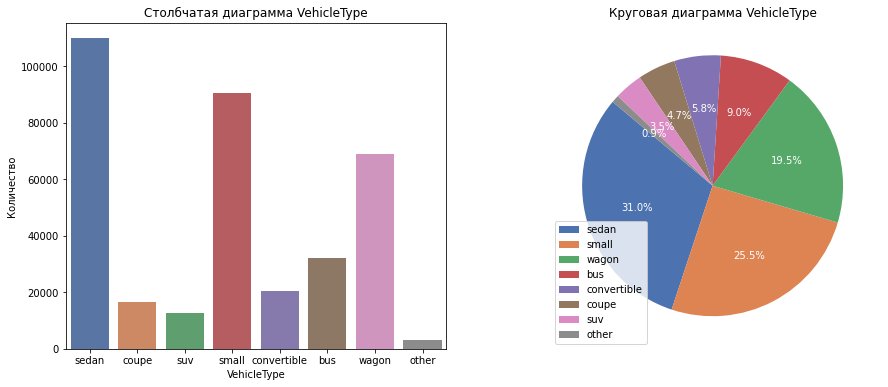

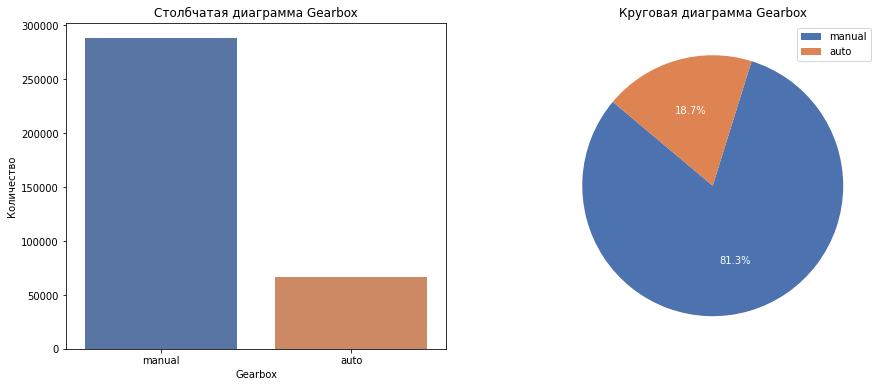

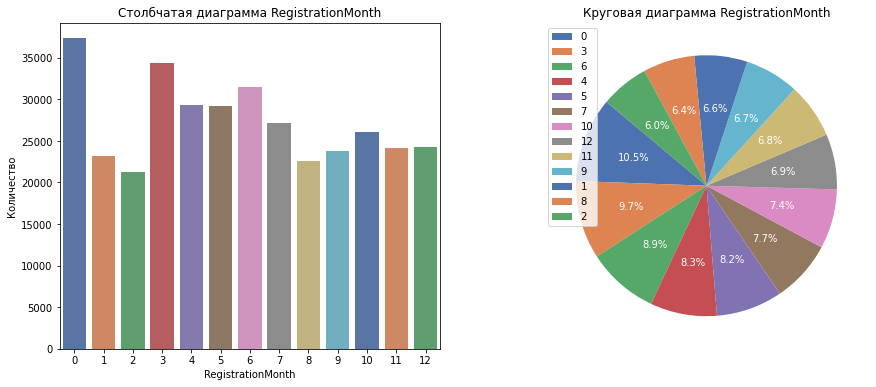

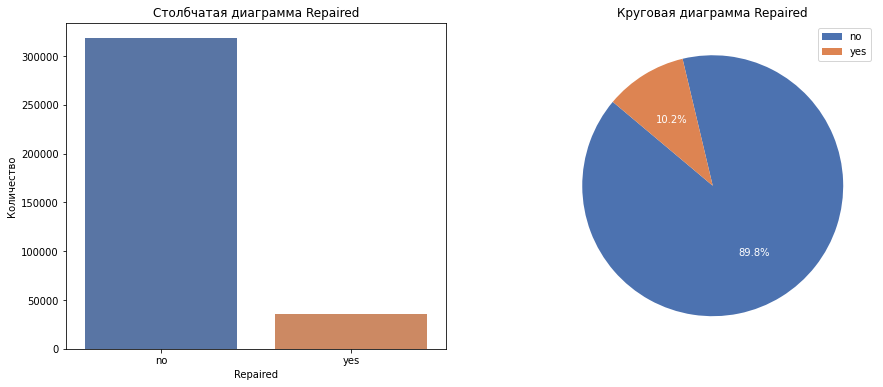

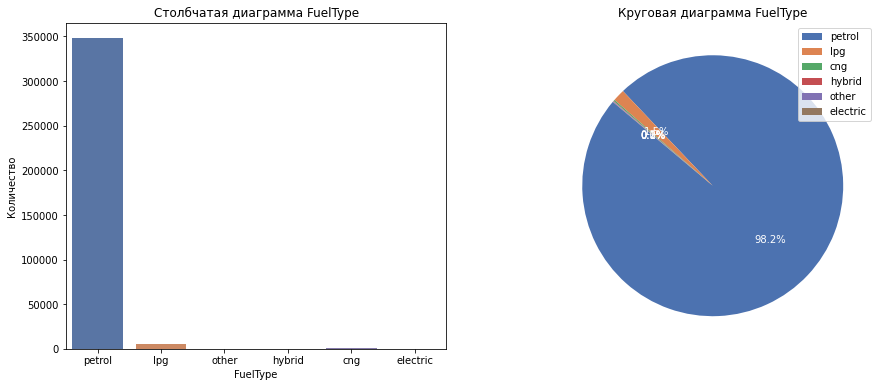

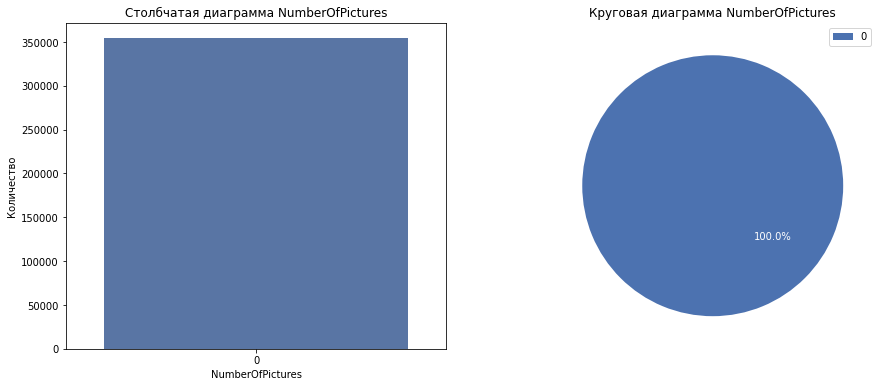

In [25]:
cat_cols = ['VehicleType', 'Gearbox', 'RegistrationMonth', 'Repaired', 'FuelType', 'NumberOfPictures']
research_vis_cat(df, cat_cols, 'deep')

Поскольку в некоторых категориальных признаках множество уникальных значений, я вынесу диаграммы по ним отдельно от шаблона. Для лучшей интерпретируемости ограничу и отсортирую выводимые значения.

Text(0.5, 1.0, 'Топ 25 популярных марок автомобилей')

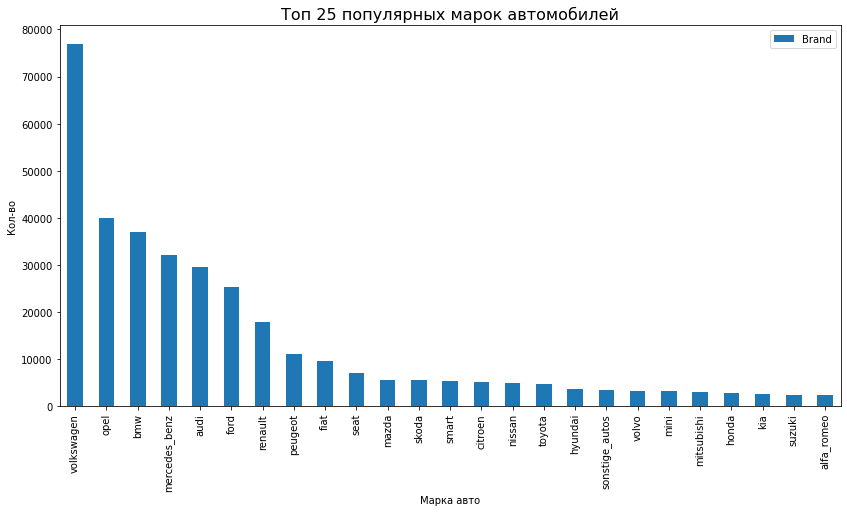

In [26]:
#sns.barplot(df.groupby('Brand').count(), x='Brand', y='count')
df['Brand'].value_counts().sort_values(ascending=False)[:25].plot(kind='bar', legend=True, figsize=(14,7))
plt.ylabel('Кол-во')
plt.xlabel('Марка авто')
plt.title('Топ 25 популярных марок автомобилей', fontsize=16)

Text(0.5, 1.0, 'Топ 25 популярных моделей автомобилей')

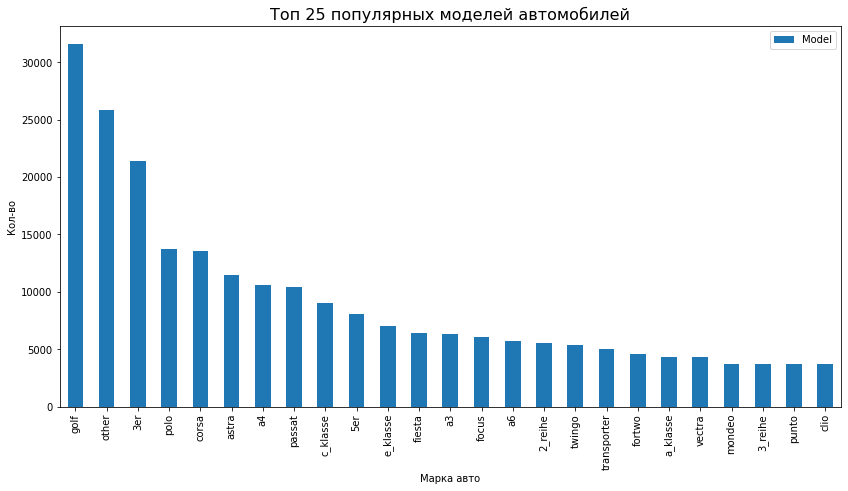

In [27]:
df['Model'].value_counts().sort_values(ascending=False)[:25].plot(kind='bar', legend=True, figsize=(14,7))
plt.ylabel('Кол-во')
plt.xlabel('Марка авто')
plt.title('Топ 25 популярных моделей автомобилей', fontsize=16)

In [28]:
df.DateCreated.dt.year.max()

2016

In [29]:
df = df.query('1970 < RegistrationYear <= 2016')

Text(0.5, 1.0, 'Топ 25 регистраций авто по годам')

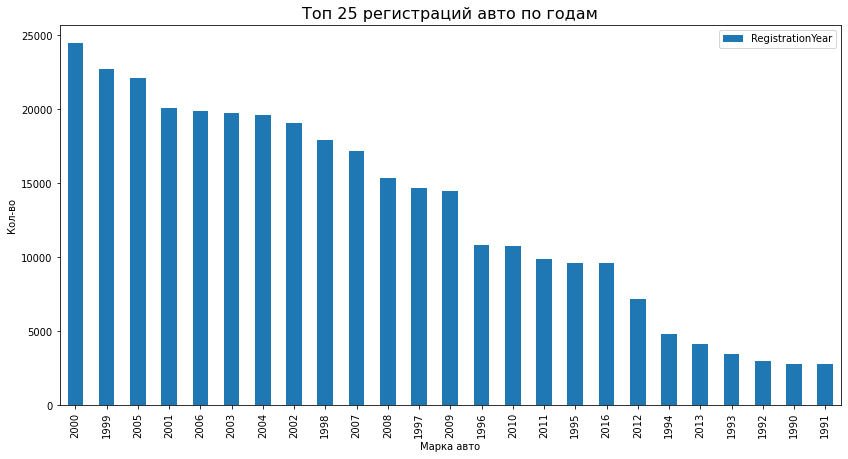

In [30]:
df['RegistrationYear'].value_counts().sort_values(ascending=False)[:25].plot(kind='bar', legend=True, figsize=(14,7))
plt.ylabel('Кол-во')
plt.xlabel('Марка авто')
plt.title('Топ 25 регистраций авто по годам', fontsize=16)

Первичный вывод по категориальным признакам:

    - Самый популярный тип кузова(VehiclelType) это sedan, small, wagon, совокупно занимаю 2/3 всех обьектов датасета. Признак важный и обязателен для обьявления, пользователи часто пользуются фильтром по типу кузова, чтобы найти подходящий авто.
    
    - Среди объявлений подавляющее кол-во машин с механической коробкой передач, признак Gearbox.
    
    - Значения по RegistrationMonth уравновешены и никакой пользы не представляют, дата регистрации обычно указана в документах, а доступ к ним покупатель получает непосредственно во время выхода на сделку в реале. Всё тоже самое можно сказать про признаки RegistrationYear. 
    
    - 90 % автомобилей не ремонтировалось, что значит серьзного технического обслуживания с заменой множества деталей у них не было.
    
    - Абсолютное большинство автомобилей работает на бензине.
    
    - Признак кол-во фотографий интерпретировать трудно, логичнее будет удалить этот шум из датасета.


<div class="alert alert-block alert-success">
<b>Успех:</b> Неплохой осмотр данных
</div>

### Количественные признаки

In [31]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,338164.000000,338164.000000,338164.000000,338164.000000,338164.000000,338164.0,338164.000000
mean,4461.486211,2002.684375,111.216652,128336.561550,5.765924,0.0,50614.448132
std,4535.426539,6.385979,185.152479,37627.266831,3.706376,0.0,25796.921322
min,0.000000,1971.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1099.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30173.000000
50%,2799.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49497.000000
75%,6500.000000,2007.000000,143.000000,150000.000000,9.000000,0.0,71229.000000
max,20000.000000,2016.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [32]:
num_cols=['Price', 'Power', 'Kilometer']
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Price,338164.0,4461.486211,4535.426539,0.0,1099.0,2799.0,6500.0,20000.0
Power,338164.0,111.216652,185.152479,0.0,69.0,105.0,143.0,20000.0
Kilometer,338164.0,128336.561550,37627.266831,5000.0,125000.0,150000.0,150000.0,150000.0


In [33]:
df = df.query('Price >= 100')

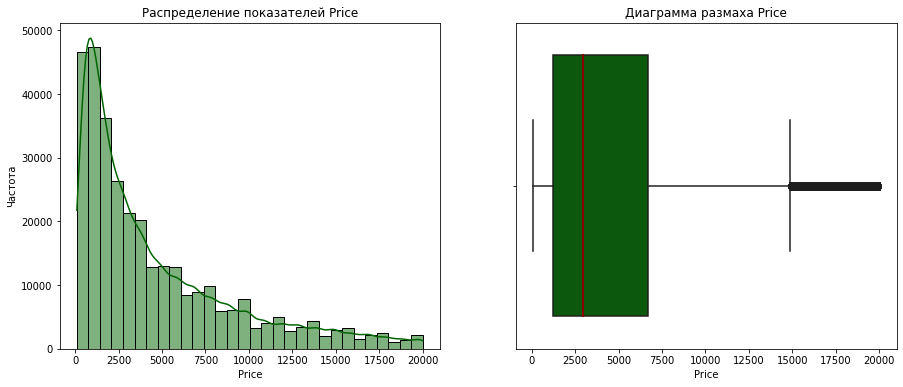

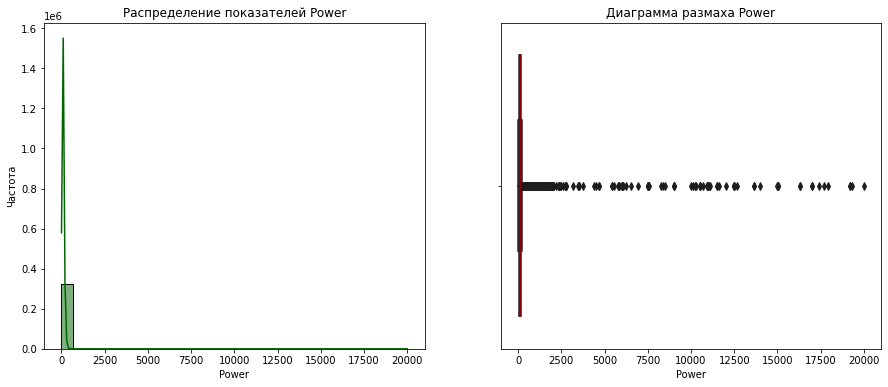

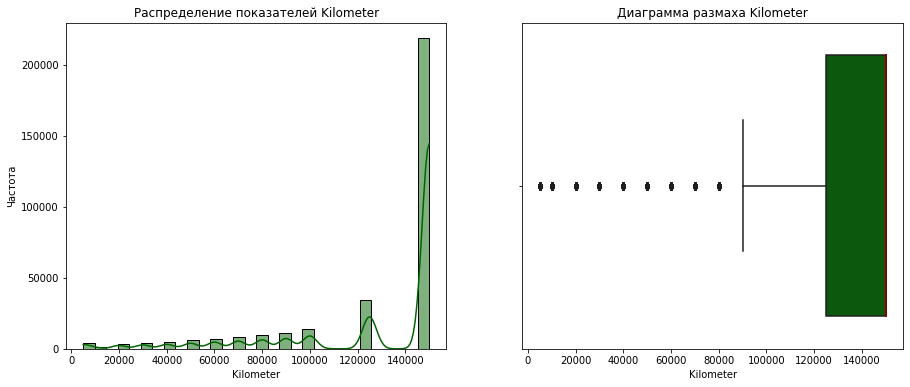

In [34]:
researchvis_num_features(df, num_cols, 'darkgreen')

По цене авто и пробегу в км никаких нареканий нет, всё выглядит правдоподобно. Но есть явные проблемы с мощностью в л.с, с наличием аномалий с кол-вом лошадиных сил свыше 1000. Скорее всего это опечатка и эти данные не с ледует удалять, а попросту убрать лишние нули.

<div class="alert alert-block alert-info">
<b>Совет:</b>  А около-нулевые цены, не кажется подозрительными? Самое интересное, что на нескольких сайтов по продажам подержанных автомобилей в Германии (страну можно определить по почтовым индексам, большинство из них из Германии) показало, что цены начинаются действительно с 0 и 1 евро, но это единичные объявления и не понятно, то ли это ошибка при заполнении формы, то ли машины на металлолом. Но я  все-таки склоняюсь к тому, чтобы избавиться от таких данных
</div>


<div class="alert alert-block alert-info">
<b>Комментарий студента</b> Резонно, ценообразование у таких авто определить сложно, а еще сложнее предсказывать
</div>


<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Упустил неадекватные значения в годе регистрации
</div>

<div class="alert alert-block alert-info">
<b>Комментарий студента</b> Подправил, действительно аномалия, я как-то провозился и забыл вернуться к этим моментам
</div>

<div class="alert alert-block alert-success">
    
<b>Успех[2]:</b> Есть
</div>

In [35]:
def make_power_true(power):
    
    if 500<power<5_000:
        return int(power/10)
    
    elif power>=5_000:
        return int(power/100)
    
    else:
        return power

<div class="alert alert-block alert-info">
<b>Совет:</b> А около-нулевые мощности?
</div>

<div class="alert alert-block alert-info">
<b>Комментарий студента</b> Согласен, тогда поставлю мининимальное в 15 л.с, начнем с малолитражек)
</div>


<div class="alert alert-block alert-info">
<b>Совет[2]:</b>  Вопрос на подумать: Как думаешь а машины с 0-ой мощностью могут быть просто без двигателя?
</div>


In [36]:
df = df.query('Power >= 15')

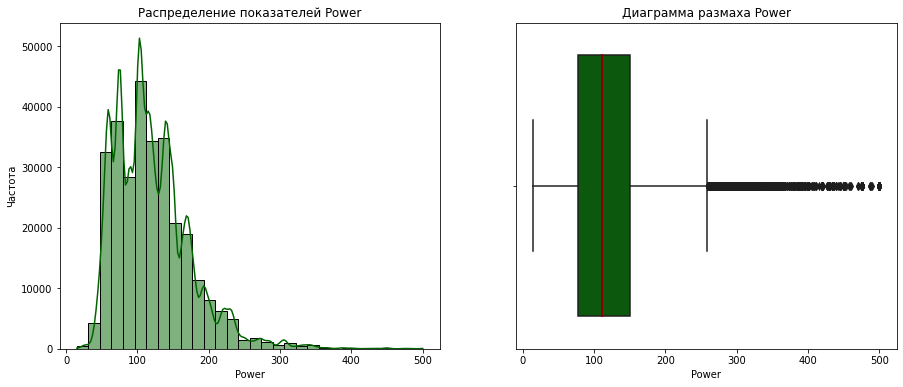

In [37]:
df.Power = df.Power.apply(make_power_true)
researchvis_num_features(df, ['Power'], 'darkgreen')

### Корреляционный анализ

 Не помешает убрать из прогнозирования признаки связанные с датировкой обьявления, а также признаки с почтовым индексом и кол-вом фотографий в объявлении. Эти фичи не вносят никакого вклада в формирование цены

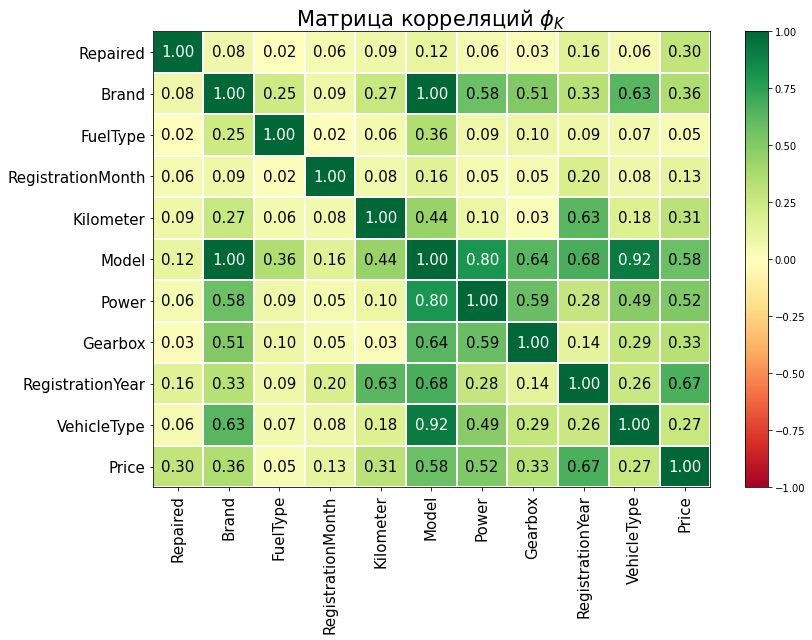

In [38]:
df = df.drop(['DateCrawled', 'LastSeen', 'DateCreated', 'PostalCode', 'NumberOfPictures'], axis=1)
phik_features_matrix(df, num_cols)


<div class="alert alert-block alert-success">
<b>Успех:</b> Удалить неинформативные признаки - верное решение
</div>

В основном матрица корреляций выглядит штатно. Присутствует однозначная зависимость между маркой и моделью авто, что абсолютно логично. Можно оставить как есть, а можно обьеденить модели авто с соответсвующими им маркам автомобилей. Также присутсвует сильная корреляция между типом кузова и моделью, в чем нет никаких противоречий, Audi A4 это всегда седан, всё тоже самое и с остальными моделями. Корреляция по Фику между мощностью двигателя и моделью, также высока - 0.75, в этом нет ничего странного каждая модель имеет свой набор конфигураций двигателя. 

Также следует искулючить из датасета признаки с месяцем регистрации и типом топлива. Поскольку абсолютное большинство автомобилей в ген совокупности бензиновые.

<div class="alert alert-block alert-success">
<b>Успех:</b> С толпивом допустимое решение
</div>



<div class="alert alert-block alert-info">
<b>Совет:</b> Но не сильно соглсаен с тем, что удалять нужно и бренд и модель одновременно, я бы что-то из них отставил, например бренд . Ты удалил бренд, потому что есть зависимость с моделью, а модель удалил потому что есть зависимость с мощностью, но потом отмечаешь, что у каждой модели есть свои конфигурации, тогда зачем ее удалять?) 
</div>

<div class="alert alert-block alert-info">
<b>Комментарий студента</b> Соглашусь, перебор)
</div>

<div class="alert alert-block alert-success">
    
<b>Успех[2]:</b> 👍
</div>

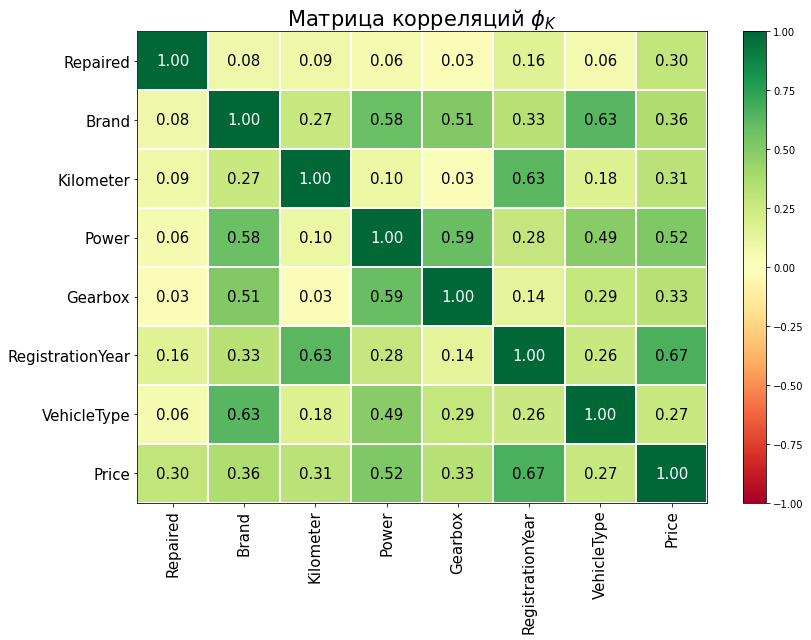

In [39]:
df = df.drop(['RegistrationMonth', 'FuelType'], axis=1)
df_matrix = df.drop(['Model'], axis=1)
phik_features_matrix(df_matrix, num_cols)

После заполнения множества пропусков и удаления колонок могло появиться множество неявных дубликатов, их следует удалить

In [40]:
df.duplicated().sum()

51668

In [41]:
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 242936 entries, 1 to 354368
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             242936 non-null  int64 
 1   VehicleType       242936 non-null  object
 2   RegistrationYear  242936 non-null  int64 
 3   Gearbox           242936 non-null  object
 4   Power             242936 non-null  int64 
 5   Model             242936 non-null  object
 6   Kilometer         242936 non-null  int64 
 7   Brand             242936 non-null  object
 8   Repaired          242936 non-null  object
dtypes: int64(4), object(5)
memory usage: 18.5+ MB



<div class="alert alert-block alert-success">
<b>Успех:</b> В целом хорошая, детальная предобработка - идем дальше
</div>

<div class="alert alert-block alert-info">
<b>Совет:</b> 

 Советую обратить внимание на библиотеки sweetviz и ydata_profiling помогут в проведении более тщательного EDA анализа. Я использую их в своей работе для первичного осмотра данных, но это можно делать и с помощью ручного вызова функций дефолтных библиотек. Данные библиотеки хороши для максимизации комфорта презентации результатов анализа бизнес-пользователям. 
    
Очень просты в использоовании, на вход кладется датафрейм: ydata_profiling.ProfileReport(df) 
</div>


<div class="alert alert-block alert-info">
<b>Комментарий студента</b> Подправил, действительно аномалия, я как-то провозился и забыл вернуться к этим моментам
</div>

## Обучение моделей

In [42]:
ohe_cols = ['Gearbox', 'Repaired']
ord_cols = ['VehicleType', 'Model', 'Brand', 'RegistrationYear']
cat_cols = ohe_cols+ord_cols
num_cols = ['Kilometer', 'Power']
RANDOM_STATE = 12345

In [43]:
ord_pipe = Pipeline([
    
    ('simpleimputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ord', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value=np.nan)),
        ( 'simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    )
])

In [44]:
ohe_pipe = Pipeline(
    [( 'simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),   
    ( 'ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

In [45]:
preprocessor_cat = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_cols),
        ('ord', ord_pipe, ord_cols),
        ('num', StandardScaler(), num_cols)
    ],
    remainder='passthrough'
)


<div class="alert alert-block alert-success">
<b>Успех:</b> Микс из кодировщиков хорошее решение. 

In [46]:
pipe_final = Pipeline([
    
    ('preprocessor', preprocessor_cat),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [47]:
params_grid = [
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [48]:
params_rs = [
    
    {
        'models': [CatBoostRegressor(random_state=RANDOM_STATE, verbose=10), 
                   LGBMRegressor(random_state=RANDOM_STATE)],
        'models__learning_rate':  [0.1, 0.25], 
        'models__max_depth': [10, 12],
        'models__n_estimators': [200], 
        'preprocessor__num': ['passthrough']
    },

    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(3, 5),
        'models__min_samples_split': range(3, 5),
        'models__min_samples_leaf': range(3, 5),
        'preprocessor__num': ['passthrough']
    }
]

In [49]:
X = df.drop(columns=['Price'])
y = df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

In [50]:
rscv = GridSearchCV(
    pipe_final,
    param_grid=params_rs,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error'
)

In [51]:
rscv.fit(X_train, y_train)
rscv.best_estimator_

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


0:	learn: 4355.2867966	total: 90.8ms	remaining: 18.1s
10:	learn: 2581.4955597	total: 432ms	remaining: 7.42s
20:	learn: 2084.6637334	total: 773ms	remaining: 6.59s
30:	learn: 1919.7805422	total: 1.12s	remaining: 6.12s
40:	learn: 1841.1372622	total: 1.49s	remaining: 5.78s
50:	learn: 1799.6410844	total: 1.87s	remaining: 5.46s
60:	learn: 1767.1546691	total: 2.23s	remaining: 5.09s
70:	learn: 1742.3590145	total: 2.58s	remaining: 4.68s
80:	learn: 1721.4194805	total: 2.98s	remaining: 4.37s
90:	learn: 1705.6490463	total: 3.43s	remaining: 4.11s
100:	learn: 1690.3349708	total: 3.78s	remaining: 3.71s
110:	learn: 1676.9784149	total: 4.13s	remaining: 3.31s
120:	learn: 1664.6656259	total: 4.48s	remaining: 2.93s
130:	learn: 1653.4670079	total: 4.84s	remaining: 2.55s
140:	learn: 1644.4314376	total: 5.21s	remaining: 2.18s
150:	learn: 1636.2628956	total: 5.56s	remaining: 1.8s
160:	learn: 1626.2031778	total: 5.91s	remaining: 1.43s
170:	learn: 1619.3922190	total: 6.25s	remaining: 1.06s
180:	learn: 1611.3742

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Gearbox', 'Repaired']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleimputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['VehicleType', 'Model',
                                                   'Brand',
                                                   'RegistrationYear']),
                                                 ('num', 'passthrough',
                                                  ['Kilometer', 'Power'])])),
                ('models',
                 <catboost.core.CatBoostRegressor object at 0x7f62f8ef86d0>)])

In [52]:
np.abs(rscv.best_score_)

1631.2128551102805

Результат посредственный, но меньше 2500 евро, что самое главное

## Анализ моделей

In [53]:
best_model_df = pd.DataFrame(rscv.cv_results_)[['param_models', 'mean_test_score', 'mean_fit_time', 'mean_score_time']]

best_model_df.mean_test_score = -best_model_df.mean_test_score

In [54]:
best_model_df['model_name']= best_model_df.param_models.astype(str).apply(lambda x: re.search('[A-Z][A-Za-z]*', x).group())

In [55]:
best_model_df.groupby('model_name').agg({'mean_test_score': 'mean',
            'mean_fit_time': 'mean',
            'mean_score_time': 'mean'}).sort_values(['mean_test_score', 'mean_fit_time', 'mean_score_time'], ascending=False)

,mean_test_score,mean_fit_time,mean_score_time
model_name,,,
DecisionTreeRegressor,2831.016865,0.512709,0.071834
LGBMRegressor,1666.760234,21.222803,0.522773
CatBoostRegressor,1650.876992,11.126195,0.175236


Лучшие результаты показал CatBoostRegressor	от яндекса, с RMSE в 1650 евро и с неплохими показателями скорости обучения и выполнения прогноза, относительно DecisionTreeRegressor, который обладает худшими результатами RMSE, несмотря на лучшую скорость работу среди бустингов. 

<div class="alert alert-block alert-success">
    
<b>Успех[2]:</b> Анализ проведен, выбор модели обоснован!
</div>

In [56]:
print(f'Метрика RMSE на тестовой выборке лучшей модели: {root_mean_squared_error(y_test, rscv.best_estimator_.predict(X_test))}')

Метрика RMSE на тестовой выборке лучшей модели: 1626.5319928173333


На тестовых данных качество немного подросло.

<div class="alert alert-block alert-success">
    
<b>Успех[2]:</b> Отличное качество на тестовых
</div>

### Выводы:

1) Данные были исследованы и обработаны:

    -удалены дубликаты;
    -отфильтрованы некорректные данные;
    -устранены пропуски;
    -проведен feature engineering.
    
2) Выполнен статистический и корреляционный анализ:

    -выявлены и устранены аномалии;
    -оценена корреляция между переменными;
    -удалены неинформативыне для прогноза признаки;
    
3) Обучены две модели регрессии:

    -подготовлен пайплайн;
    -использованы модели градиентного бустинга и дерева решений;
    -по результатам кросс-валидации наилучшей признана модель CatBoostRegressor с метрикой RMSE 1626 евро.
    
4) Проведен анализ скорости работы моделей:

    ##### Наилучшую скорость показала модель дерева решений, однако с неудовлетворительным значеним целевой метрики;
    
    ##### Самой быстрой и точной моделью среди градиентного бустинга оказалась CatBoostRegressor.

<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично проделан шаг
    
- Кросс-валидационные методы успешно использованы. 
- Все метрики интересующие заказчика лаконично вычислены 
- Всегда приятно наблюдать информативную таблицу.
</div>


<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Нужно провести анализ метрик, не чтобы выбрать худшую модель, а чтобы выбрать одну лучшую модель
</div>

После твоей проверки добавлю финальный вывод, поскольку я пока не уверен, что тут всё окей.

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> После анализа и выбора одной наилучшей модели, должно идти  ее тестирование. Другие модели тестовую выборку использовать не должны.
</div>

<div class="alert alert-block alert-info">
<b>Совет:</b> 

Также если говорить, что можно ещё улучшить в подобных проектах, то я бы выделил такие моменты:<br>
    
1) Для понимания, а какие в итоге факторы важны при моделировании, можно выводить их важность, использую feature_importances_, ну и график заодно. Это будет смотреться очнь здорово: результативная метрика и график важности факторов)))
    
2) У нас разный возраст машин. Есть гипотеза, что для разных возрастов - своё ценообразование. Поэтому, можно попробовать ввести фактор "тип возраста" (ретро, супер-ретро, старая, новая... надо подумать..)..<br>

3) У некоторых моделей семейства бустингов, есть внутренний метод кодировки данных, который хорошо было бы попробовать
</div>


## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей